<a href="https://colab.research.google.com/github/purvasingh96/pytorch-examples/blob/master/Images/02_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
data_transforms = {
    'train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
                                transforms.Resize(256), 
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


    ])
}


In [7]:
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of hymenoptera_data.zip or
        hymenoptera_data.zip.zip, and cannot find hymenoptera_data.zip.ZIP, period.


In [10]:
!unzip hymenoptera_data.zip
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                    for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
                    for x in ['train', 'val']}
trainloader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=4, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=4, shuffle=True, num_workers=2)
dataset_sizes = {x: len(image_datasets[x])
                    for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(class_names)


Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  best_model = copy.deepcopy(model.state_dict())
  best_acc=0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-'*10)

    for phase in ['train', 'val']:
      if phase=='train':
        model.train()
      else:
        model.eval()
      running_loss=0.0
      running_correct=0.0
      for inputs, labels in dataloaders[phase]:
        inputs=inputs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase=='train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_correct += torch.sum(preds==labels.data)
      if phase=='train':
        scheduler.step()
      
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_correct.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc>best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
  
  model.load_state_dict(best_model)
  return model



In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False

num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, 2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [18]:
model_conv = train_model(model_conv, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8181 Acc: 0.5697
val Loss: 0.2121 Acc: 0.9346
Epoch 1/24
----------
train Loss: 0.5546 Acc: 0.7541
val Loss: 0.1869 Acc: 0.9542
Epoch 2/24
----------
train Loss: 0.4214 Acc: 0.7869
val Loss: 0.1792 Acc: 0.9542
Epoch 3/24
----------
train Loss: 0.5402 Acc: 0.7582
val Loss: 0.1794 Acc: 0.9477
Epoch 4/24
----------
train Loss: 0.4255 Acc: 0.8156
val Loss: 0.1789 Acc: 0.9542
Epoch 5/24
----------
train Loss: 0.4315 Acc: 0.8074
val Loss: 0.2989 Acc: 0.9085
Epoch 6/24
----------
train Loss: 0.4285 Acc: 0.8238
val Loss: 0.2846 Acc: 0.9020
Epoch 7/24
----------
train Loss: 0.4458 Acc: 0.7746
val Loss: 0.1809 Acc: 0.9608
Epoch 8/24
----------
train Loss: 0.3740 Acc: 0.8156
val Loss: 0.1909 Acc: 0.9542
Epoch 9/24
----------
train Loss: 0.3112 Acc: 0.8484
val Loss: 0.1963 Acc: 0.9542
Epoch 10/24
----------
train Loss: 0.4182 Acc: 0.8156
val Loss: 0.1734 Acc: 0.9542
Epoch 11/24
----------
train Loss: 0.4174 Acc: 0.8115
val Loss: 0.1944 Acc: 0.9542
Epoch 12/24
--

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


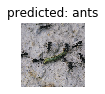

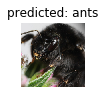

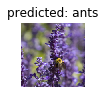

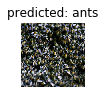

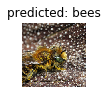

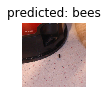

In [24]:
visualize_model(model_conv)